<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Config" data-toc-modified-id="Config-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Config</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Generate" data-toc-modified-id="Generate-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Generate</a></span></li><li><span><a href="#Denoise" data-toc-modified-id="Denoise-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Denoise</a></span><ul class="toc-item"><li><span><a href="#Noisy-images" data-toc-modified-id="Noisy-images-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Noisy images</a></span></li><li><span><a href="#Denoising" data-toc-modified-id="Denoising-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Denoising</a></span></li></ul></li></ul></div>

## Imports

In [1]:
import functools
import torch
import tqdm
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import Adam
from torch.utils.data import DataLoader

# import utils from github repo
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    if os.path.isdir('./diffusion-for-photoacoustic/') == False:
        ! git clone https://github.com/snigdhasaha7/diffusion-for-photoacoustic.git
    sys.path.append('./diffusion-for-photoacoustic/')

import samplers
from models import ScoreNet
from sdes import Classic, VarianceExploding, VariancePreserving, SubVariancePreserving

## Config

In [2]:
n_epochs = 50
batch_size = 64
lr = 1e-4
device = 'cpu'         # ['cuda', 'cpu']
dataset = 'FashionMNIST'    # ['MNIST', 'FashionMNIST', 'CIFAR10']
sde_type = 've'   # ['classic', 'vp', 've', 'subvp']
sde_params = [0.01, 5]         # [classic: sigma][vp: b_min, b_max][ve|subve: s_min, s_max]
gen_sampler = 'pc'     # ['em', 'pc', 'ode']
denoise_sampler = 'pc' # ['em', 'pc']
noise_std = .1
training = False
denoising = True

## Setup

In [3]:
# SDE
if sde_type == 've':
    SDE = VarianceExploding()
    sigma_min, sigma_max = sde_params
    params_str = '{}_{}'.format(*sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, sigma_min=sigma_min, sigma_max=sigma_max)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, sigma_min=sigma_min, sigma_max=sigma_max)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, sigma_min=sigma_min, sigma_max=sigma_max)
elif sde_type == 'vp':
    SDE = VariancePreserving()
    beta_min, beta_max = sde_params
    params_str = '{}_{}'.format(*sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, beta_min=beta_min, beta_max=beta_max)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, beta_min=beta_min, beta_max=beta_max)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, beta_min=beta_min, beta_max=beta_max)
elif sde_type == 'subvp':
    SDE = SubVariancePreserving()
    beta_min, beta_max = sde_params
    params_str = '{}_{}'.format(*sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, beta_min=beta_min, beta_max=beta_max)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, beta_min=beta_min, beta_max=beta_max)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, beta_min=beta_min, beta_max=beta_max)
elif sde_type == 'classic':
    SDE = Classic()
    sigma = sde_params
    params_str = '{}'.format(sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, sigma=sigma)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, sigma=sigma)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, sigma=sigma)
    
# sampler for generation
if gen_sampler == 'em':
    sampler = samplers.Euler_Maruyama_sampler
elif gen_sampler == 'pc':
    sampler = samplers.pc_sampler
elif gen_sampler == 'ode':
    sampler = samplers.ode_sampler

# sampler for denoising
if denoise_sampler == 'em':
    denoiser = samplers.Euler_Maruyama_denoiser
elif denoise_sampler == 'pc':
    denoiser = samplers.pc_denoiser

# training dataset
if training:
    if dataset == 'MNIST':
        train_transforms = transforms.Compose([transforms.ToTensor()])
        train_dataset = MNIST('.', train=True, transform=train_transforms, download=True);
    elif dataset == 'FashionMNIST':
        train_transforms = transforms.Compose([transforms.ToTensor()])
        train_dataset = FashionMNIST('.', train=True, transform=train_transforms, download=True);
    elif dataset == 'CIFAR10':
        train_transforms = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
             transforms.Resize((28,28)),
             transforms.Grayscale(num_output_channels=1)])
        train_dataset = CIFAR10('.', train=True, transform=train_transforms, download=True);
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4);

# noisy dataset
class AddGaussianNoise():
    ''' Adds some Gaussian Noise ~ N(0, std^2 I) to an image
    '''
    # structure for custom transform follows pytorch source code
    # https://pytorch.org/vision/stable/_modules/torchvision/transforms/transforms.html
    def __init__(self, std=1.):
        self.std = std

    def __call__(self, image):
        ''' Add noise, returns noisy image'''
        noise = self.std * torch.randn_like(image)
        return image + noise
    def __repr__(self):
        return f"{self.__class__.__name__}()"

if denoising:
    if dataset == 'MNIST':
        test_transforms = transforms.Compose([transforms.ToTensor(), AddGaussianNoise(noise_std)])
        test_dataset = MNIST('.', train=False, transform=test_transforms, download=True);
    elif dataset == 'FashionMNIST':
        test_transforms = transforms.Compose([transforms.ToTensor(), AddGaussianNoise(noise_std)])
        test_dataset = FashionMNIST('.', train=False, transform=test_transforms, download=True);
    elif dataset == 'CIFAR10':
        test_transforms = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
             transforms.Resize((28,28)),
             transforms.Grayscale(num_output_channels=1),
             AddGaussianNoise(noise_std)])
        test_dataset = CIFAR10('.', train=False, transform=test_transforms, download=True);
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4);

# model + optimizer
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)

# loss
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

## Training

In [ ]:
# training
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in train_loader:
        x = x.to(device)    
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0] 
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), './checkpoints/ckpt_{}_{}epochs_{}_{}.pth'.format(dataset.lower(), n_epochs, sde_type, params_str))

## Generate

In [4]:
# Load model
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
model_pth = './checkpoints/ckpt_{}_{}epochs_{}_{}.pth'.format(dataset.lower(), n_epochs, sde_type, params_str)
ckpt = torch.load(model_pth, map_location=device)
score_model.load_state_dict(ckpt)

# Set up sampler
def sample(sampler):
    samples = sampler(score_model, 
                    marginal_prob_std_fn,
                    diffusion_coeff_fn,
                    drift_coeff_fn,
                    batch_size, 
                    device=device)
    return samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


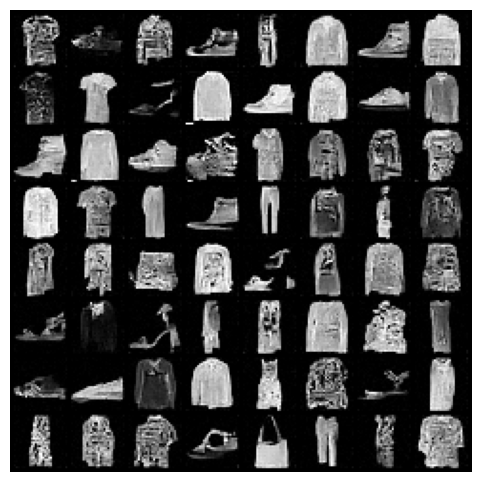

In [6]:
# Generate samples
samples = sample(sampler)
samplers.plot_images(samples)

## Denoise

In [4]:
# Load model
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
model_pth = './checkpoints/ckpt_{}_{}epochs_{}_{}.pth'.format(dataset.lower(), n_epochs, sde_type, params_str)
ckpt = torch.load(model_pth, map_location=device)
score_model.load_state_dict(ckpt)

# Set up denoiser
def denoise(raw_images, denoiser, lbda=.5, lbda_schedule='constant', lbda_param=1):
    denoised = denoiser(raw_images,
                    score_model,
                    lbda,
                    marginal_prob_std_fn,
                    diffusion_coeff_fn,
                    drift_coeff_fn,
                    lbda_schedule,
                    lbda_param,
                    device=device)
    return denoised

### Noisy images

In [5]:
num_images = 5
data, _ = next(iter(test_loader))
noisy_images = data[:num_images].to(device)

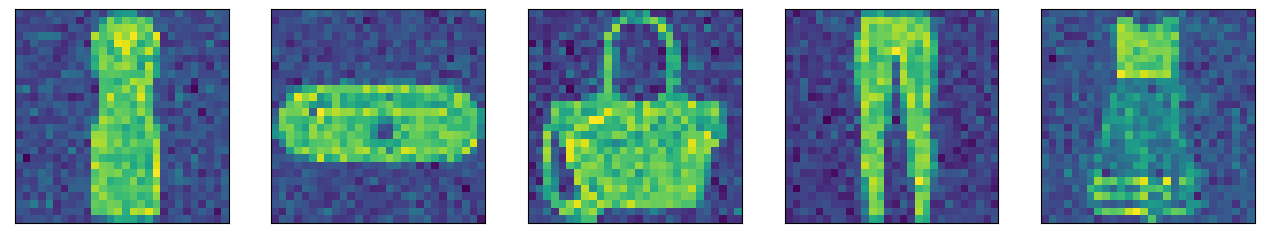

In [6]:
fig, axs = plt.subplots(1, noisy_images.shape[0], figsize=(16, 8))
for i, image in enumerate(noisy_images):
    axs[i].imshow(image.cpu().permute(1, 2, 0).squeeze())
    axs[i].set_xticks([])
    axs[i].set_yticks([])

### Denoising

In [7]:
denoised_images = denoise(noisy_images, denoiser, lbda=.01, lbda_schedule='linear', lbda_param=1)

  0%|          | 0/500 [00:00<?, ?it/s]

/home/laure/projects/diffusion-for-photoacoustic/sdes.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  drift = torch.zeros_like(torch.tensor(x, device=t.device))


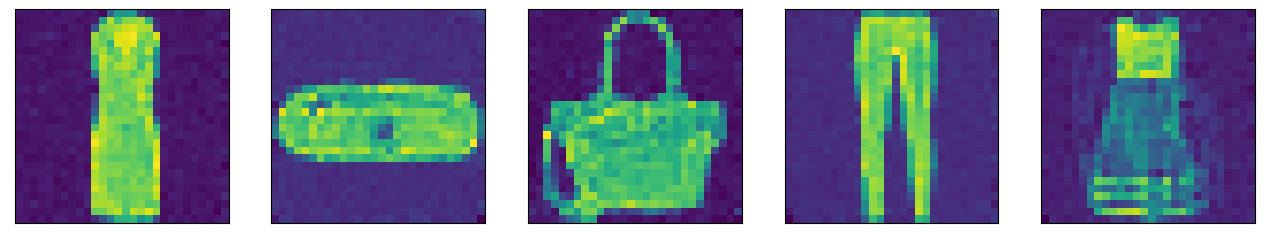

In [8]:
fig, axs = plt.subplots(1, denoised_images.shape[0], figsize=(16, 8))
for i, image in enumerate(denoised_images):
    axs[i].imshow(image.cpu().permute(1, 2, 0).squeeze())
    axs[i].set_xticks([])
    axs[i].set_yticks([])